# Alternating Least Squares (ALS) for Matrix Factorization

## Initial Assumptions

In this exploration of Alternating Least Squares (ALS) for matrix factorization, we start with the same example data from a previous post. Recall that we have a user-by-item matrix where nonzero elements represent the ratings given by users to items. Matrix factorization assumes the following:

- Each user can be described by *k* attributes or features. For example, feature 1 might indicate how much each user likes sci-fi movies.
- Each item (movie) can be described by an analogous set of *k* attributes or features. Feature 1 for a movie might represent how close the movie is to pure sci-fi.
- If we multiply each feature of the user by the corresponding feature of the movie and add everything together, this sum provides a good approximation for the rating the user would give that movie.

The beauty of matrix factorization lies in the fact that we don't know these features beforehand, nor do we know how many (*k*) features are relevant. We arbitrarily select a number for *k* and learn the relevant values for all features for all users and items by minimizing a loss function.

## Loss Function

We formulate the loss function to be minimized as follows:

$$L = \sum\limits_{u,i \in S}(r_{ui} - \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i})^{2} + \lambda_{x} \sum\limits_{u} \left\Vert \textbf{x}_{u} \right\Vert^{2} + \lambda_{y} \sum\limits_{u} \left\Vert \textbf{y}_{i} \right\Vert^{2}$$

Here:
- $r_{ui}$ is the actual rating given by user *u* to item *i*.
- $\textbf{x}_{u}$ and $\textbf{y}_{i}$ are the user and item vectors, respectively, representing the latent factors.
- $\lambda_{x}$ and $\lambda_{y}$ are regularization terms to prevent overfitting.

## Derivation of ALS

ALS minimization involves an alternating process where one set of latent vectors is held constant while the other set is updated. The process alternates between updating user vectors and item vectors. Let's derive the update equations.

### Update Equation for User Vectors $\textbf{x}_{u}$

Starting with the derivative of the loss function with respect to $\textbf{x}_{u}$:

$$\frac{\partial L}{\partial \textbf{x}_{u}} = - 2 \sum\limits_{i}(r_{ui} - \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i}) \textbf{y}_{i}^{\intercal} + 2 \lambda_{x} \textbf{x}_{u}^{\intercal}$$

Setting the derivative to zero, we solve for $\textbf{x}_{u}$:

$$\textbf{x}_{u}^{\intercal} = \textbf{r}_{u} \cdot{} \textbf{y}_{i} \cdot{} (\textbf{y}_{i}^{\intercal} \cdot{} \textbf{y}_{i} + \lambda_{x}I)^{-1}$$

### Update Equation for Item Vectors $\textbf{y}_{i}$

Similarly, the derivative of the loss function with respect to $\textbf{y}_{i}$ is:

$$\frac{\partial L}{\partial \textbf{y}_{i}} = - 2 \sum\limits_{u}(r_{ui} - \textbf{y}_{i}^{\intercal} \cdot{} \textbf{x}_{u}) \textbf{x}_{u}^{\intercal} + 2 \lambda_{y} \textbf{y}_{i}^{\intercal}$$

Setting the derivative to zero and solving for $\textbf{y}_{i}$:

$$\textbf{y}_{i}^{\intercal} = \textbf{r}_{i} \cdot{} \textbf{x}_{u} \cdot{} (\textbf{x}_{u}^{\intercal} \cdot{} \textbf{x}_{u} + \lambda_{y}I)^{-1}$$

The alternating least squares process continues by iteratively updating user vectors and item vectors until convergence.

## Implementation:

In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from scipy import sparse as sp

In [67]:
class MLDataset:
    def __init__(self, movies, ratings):
        self.movies = movies.copy()
        self.ratings = ratings.copy()
        self.m2m_new = {idx: i for i, idx in enumerate(ratings['movieId'].unique())}
        self.u2u_new = {idx: i for i, idx in enumerate(ratings['userId'].unique())}

    def convert(self):
        self.movies['movieId'] = self.movies['movieId'].apply(lambda x: self.m2m_new.get(x, -1))
        self.movies['movieId'] = self.movies['movieId'].astype(int)
        self.ratings['userId'] = self.ratings['userId'].map(self.u2u_new)
        self.ratings['movieId'] = self.ratings['movieId'].map(self.m2m_new)

        reviews_dict = self.ratings.groupby('userId').apply(lambda x: dict(zip(x['movieId'], x['rating']))).to_dict()
        m2title = {m_id: title for m_id, title in zip(self.movies['movieId'].values, self.movies['title'].values)}
        title2m = {title:m_id for m_id, title in zip(self.movies['movieId'].values, self.movies['title'].values)}
        return self.movies, reviews_dict, self.ratings, m2title, title2m
    
    def train_test_split(self, num_test_samples=10):
        train_ratings, test_ratings = [], []
        for userId, user_data in self.ratings.groupby('userId'):
            n_samples = len(user_data)
            if n_samples < 2*num_test_samples:
                train_ratings += user_data
            else:
                train_ratings += [user_data[:-num_test_samples]]
                test_ratings += [user_data[-num_test_samples:]]
        train_ratings = pd.concat(train_ratings)
        test_ratings = pd.concat(test_ratings)
        return train_ratings, test_ratings


In [68]:
movies_original = pd.read_csv('datasets/ml-latest-small/movies.csv')
ratings_original = pd.read_csv('datasets/ml-latest-small/ratings.csv')

ml_dataset = MLDataset(movies_original, ratings_original)

movies_original, ratings_dict, ratings_original, m2title, title2m = ml_dataset.convert()

train_ratings, test_ratings = ml_dataset.train_test_split()

print(train_ratings.shape, test_ratings.shape)

(94736, 4) (6100, 4)


In [69]:
train_ratings.head()

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,1,4.0,964981247
2,0,2,4.0,964982224
3,0,3,5.0,964983815
4,0,4,5.0,964982931


In [70]:
print(train_ratings['movieId'].max(), len(train_ratings['movieId'].unique()))
print(ratings_original['movieId'].max(), len(ratings_original['movieId'].unique()))

9721 9361
9723 9724


In [71]:
class ALSRecSys:
    def __init__(self, num_users, num_items, m2title, num_dims=30):
        self.num_dims = num_dims
        self.num_users = num_users
        self.num_items = num_items
        self.m2title = m2title
        self.title2m = {title: movie_id for movie_id, title in self.m2title.items()}
        self.train_ratings = None
        self.test_ratings = None
        self.R = None
        self.history = {'train_rmse': [], 'test_rmse': []}
        self.X = None
        self.Y = None
    
    def _reset(self):
        self.train_ratings = None
        self.test_ratings = None
        self.R = None
        self.history = {'train_rmse': [], 'test_rmse': []}
        self.X = None
        self.Y = None

    def fit(self, train_ratings, test_ratings, num_iters=10, eps=1):
        self._reset()
        self.train_ratings = train_ratings.copy()
        self.test_ratings = test_ratings.copy()
        self.m2title = m2title
        self.R = self._get_R(self.train_ratings)
        self.history = []
        X, Y = self._ALS_fit(num_iters, eps)
        self.X = X
        self.Y = Y
    
    def _get_R(self, reviews):
        # Example: Create a COO matrix from the 'ratings' DataFrame
        users = reviews['userId'].values
        items = reviews['movieId'].values
        values = reviews['rating'].values

        num_users = self.num_users
        num_items = self.num_items
        # Create a sparse matrix in COO format
        R = sp.coo_array((values, (users, items)), shape=(num_users, num_items)).tocsr()
        return R

    def _ALS_fit(self, num_iters, eps):
        R = self.R
        num_dims = self.num_dims
        num_users = self.num_users
        num_items = self.num_items
        X = np.random.randn(num_users, num_dims) #Users
        Y = np.random.randn(num_items, num_dims) #Items
        
        for t in range(num_iters):
            RY = R @ Y
            for u in range(num_users):
                relevant_items = self.train_ratings[self.train_ratings['userId'] == u]['movieId'].values
                Y_rel = Y[relevant_items]
                YY = Y_rel.reshape(-1, num_dims, 1) * Y_rel.reshape(-1, 1, num_dims)
                X[u] = np.linalg.inv(YY.sum(axis=0) + eps * np.eye(num_dims)) @ RY[u]

            RX = R.T @ X
            for i in range(num_items):
                relevant_users = self.train_ratings[self.train_ratings['movieId'] == i]['userId'].values
                X_rel = X[relevant_users]
                XX = X_rel.reshape(-1, num_dims, 1) * X_rel.reshape(-1, 1, num_dims)
                Y[i] = np.linalg.inv(XX.sum(axis=0) + eps * np.eye(num_dims)) @ RX[i]
            train_rmse, test_rmse = self._get_rmse(X, Y)
            print(f"Iter: {t:>3} TRAIN RMSE: {train_rmse:5.3f} TEST RMSE: {test_rmse:5.3f}")
        return X, Y
    
    def _get_rmse(self, X, Y):
        train_preds = (X[self.train_ratings.userId] * Y[self.train_ratings.movieId]).sum(axis=1)
        test_preds = (X[self.test_ratings.userId] * Y[self.test_ratings.movieId]).sum(axis=1)
        train_preds = np.clip(train_preds, 0.5, 5)
        test_preds = np.clip(test_preds, 0.5, 5.0)
        train_rmse = root_mean_squared_error(train_preds, self.train_ratings['rating'])
        test_rmse = root_mean_squared_error(test_preds, self.test_ratings['rating'])
        return train_rmse, test_rmse

    def _get_rankings(self, user_id_mapped):
        rankings = self.Y @ self.X[user_id_mapped].T
        return rankings
    
    def get_rankings(self, user_id):
        user_id_mapped = self.u2idx[user_id]
        rankings = self._get_rankings(user_id_mapped)
        rankings = [(self.idx2m[idx], score) for idx, score in enumerate(rankings)]
        rankings = sorted(rankings, key=lambda x: x[1], reverse=True)
        return rankings
    
    def recommend(self, user_id, top_k=10, not_seen=True):
        rankings = self._get_rankings(user_id)

        if not_seen:
            viewed_items = set(self.train_ratings[train_ratings['userId'] == user_id]['movieId'])
            rankings = [(idx, score) for idx, score in enumerate(rankings) if idx not in viewed_items]
        else:
            rankings = [(idx, score) for idx, score in enumerate(rankings)]

        # Get the top k items with the highest score
        top_k_recommendations = sorted(rankings, key=lambda x: x[1], reverse=True)[:top_k]
        return top_k_recommendations
    
    def print_recommend(self, user_id, top_k=10, not_seen=True):
        top_k_recommendations = self.recommend(user_id, top_k, not_seen)
        print(*list(map(lambda x: f"id: {x[0]: <7} {self.m2title[x[0]]: <80} score: {x[1]: 4.2f}", top_k_recommendations)), sep='\n')

    def most_similar(self, movie_title, top_k=10):
        movie_id = self.title2m.get(movie_title, None)
        if movie_id is None:
            print(f'{movie_title} not found!')
            return 0
        movie_vec = self.Y[movie_id]
        similarities = []
        for i in range(self.Y.shape[0]):
            if i != movie_id:
                nom = np.dot(movie_vec, self.Y[i])
                denom = np.linalg.norm(movie_vec)*np.linalg.norm(self.Y[i])
                if not denom:
                    similarities.append((i, 0))
                else:
                    sim = nom/denom
                    similarities.append((i, sim))
        top_k_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_k]
        return top_k_similarities

    def print_most_similar(self, movie_title, top_k=10):
        top_k_most_similar = self.most_similar(movie_title, top_k)
        print(*list(map(lambda x: f"id: {x[0]: <7} {self.m2title[x[0]]: <80} score: {x[1]: 4.2f}", top_k_most_similar)), sep='\n')

In [72]:
num_items = len(ratings_original['movieId'].unique())
num_users = len(ratings_original['userId'].unique())
print(f'num_users: {num_users} num_items: {num_items}')
print()
als = ALSRecSys(num_users, num_items, m2title)
als.fit(train_ratings, test_ratings, num_iters=10, eps=2)


num_users: 610 num_items: 9724



Iter:   0 TRAIN RMSE: 1.796 TEST RMSE: 2.434
Iter:   1 TRAIN RMSE: 0.700 TEST RMSE: 1.838
Iter:   2 TRAIN RMSE: 0.520 TEST RMSE: 1.846
Iter:   3 TRAIN RMSE: 0.452 TEST RMSE: 1.859
Iter:   4 TRAIN RMSE: 0.415 TEST RMSE: 1.861
Iter:   5 TRAIN RMSE: 0.392 TEST RMSE: 1.854
Iter:   6 TRAIN RMSE: 0.375 TEST RMSE: 1.841
Iter:   7 TRAIN RMSE: 0.363 TEST RMSE: 1.827
Iter:   8 TRAIN RMSE: 0.353 TEST RMSE: 1.811
Iter:   9 TRAIN RMSE: 0.345 TEST RMSE: 1.795


In [73]:
als.print_recommend(user_id=598, not_seen=False)

id: 1437    Vertigo (1958)                                                                   score:  6.64
id: 1910    Forgetting Sarah Marshall (2008)                                                 score:  6.23
id: 1455    Heathers (1989)                                                                  score:  6.00
id: 3478    Tucker & Dale vs Evil (2010)                                                     score:  5.92
id: 301     Living in Oblivion (1995)                                                        score:  5.82
id: 2299    King Kong (2005)                                                                 score:  5.67
id: 1135    Once Upon a Time in the West (C'era una volta il West) (1968)                    score:  5.66
id: 2050    Downfall (Untergang, Der) (2004)                                                 score:  5.64
id: 2342    Assassination of Jesse James by the Coward Robert Ford, The (2007)               score:  5.59
id: 3484    Bridesmaids (2011)                

In [74]:
als.print_most_similar('Star Wars: Episode IV - A New Hope (1977)', top_k=10)

id: 68      Star Wars: Episode V - The Empire Strikes Back (1980)                            score:  0.99
id: 73      Star Wars: Episode VI - Return of the Jedi (1983)                                score:  0.98
id: 85      Back to the Future (1985)                                                        score:  0.96
id: 180     Ghostbusters (a.k.a. Ghost Busters) (1984)                                       score:  0.95
id: 70      Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)   score:  0.95
id: 166     Matrix, The (1999)                                                               score:  0.94
id: 232     Shawshank Redemption, The (1994)                                                 score:  0.94
id: 478     Terminator 2: Judgment Day (1991)                                                score:  0.93
id: 84      Groundhog Day (1993)                                                             score:  0.93
id: 4       Usual Suspects, The (1995)        

In [75]:
als.print_most_similar('Pulp Fiction (1994)', top_k=10)

id: 62      Reservoir Dogs (1992)                                                            score:  0.97
id: 192     Fight Club (1999)                                                                score:  0.97
id: 4       Usual Suspects, The (1995)                                                       score:  0.96
id: 83      Shining, The (1980)                                                              score:  0.96
id: 444     Memento (2000)                                                                   score:  0.96
id: 234     Kill Bill: Vol. 1 (2003)                                                         score:  0.96
id: 1101    One Flew Over the Cuckoo's Nest (1975)                                           score:  0.95
id: 1159    Trainspotting (1996)                                                             score:  0.95
id: 292     Twelve Monkeys (a.k.a. 12 Monkeys) (1995)                                        score:  0.95
id: 34      Silence of the Lambs, The (1991)  

In [76]:
als.print_most_similar('Lord of the Rings: The Two Towers, The (2002)', top_k=10)

id: 774     Lord of the Rings: The Return of the King, The (2003)                            score:  0.99
id: 753     Lord of the Rings: The Fellowship of the Ring, The (2001)                        score:  0.99
id: 770     Pirates of the Caribbean: The Curse of the Black Pearl (2003)                    score:  0.92
id: 794     Incredibles, The (2004)                                                          score:  0.91
id: 146     Edward Scissorhands (1990)                                                       score:  0.91
id: 1050    Children of Men (2006)                                                           score:  0.89
id: 762     Spirited Away (Sen to Chihiro no kamikakushi) (2001)                             score:  0.89
id: 875     Finding Nemo (2003)                                                              score:  0.89
id: 2234    Terminator 3: Rise of the Machines (2003)                                        score:  0.89
id: 915     Up (2009)                         

In [77]:
als.print_most_similar("Godfather, The (1972)", top_k=10)

id: 1136    Godfather: Part II, The (1974)                                                   score:  0.98
id: 74      Goodfellas (1990)                                                                score:  0.97
id: 62      Reservoir Dogs (1992)                                                            score:  0.94
id: 34      Silence of the Lambs, The (1991)                                                 score:  0.94
id: 4       Usual Suspects, The (1995)                                                       score:  0.94
id: 1101    One Flew Over the Cuckoo's Nest (1975)                                           score:  0.94
id: 72      Apocalypse Now (1979)                                                            score:  0.93
id: 67      Monty Python and the Holy Grail (1975)                                           score:  0.93
id: 121     Saving Private Ryan (1998)                                                       score:  0.93
id: 16      Pulp Fiction (1994)               

## Mean Average Precision at k (MAP@k)

Mean Average Precision at k (MAP@k) is a widely used metric to evaluate the performance of recommendation systems. It assesses the precision of the top-k recommended items by considering both the relevance and the order of the recommendations.

### MAP@k:
 is then calculated as the average of AP@k over all queries:

$$ MAP@k = \frac{\sum_{q=1}^{Q} AP@k_q}{Q} $$

Where:
- $ Q $ is the total number of queries.

### AP@k:

$$ AP@k = \frac{\sum_{i=1}^{k} \text{Precision@i} \cdot \text{rel@i}}{\text{min}(k, \text{num\_true\_positives})} $$
Where:
  - $ \text{Precision@i} $ is the precision at the $i$-th position in the ranking.
  - $ \text{rel@i} $ is an indicator function that is 1 if the item at position $i$ is relevant, and 0 otherwise.
  - $ \text{num\_true\_positives} $ is the total number of true positive items in the query.

### Precision@k:  
is a metric that evaluates the accuracy of the top-k recommendations. It is calculated using the following formula:

$$ \text{Precision@k} = \frac{\text{Number of relevant items in top-k}}{k} $$


### rel@i:

  $$ \text{rel@i} =
      \begin{cases} 
        1 & \text{if the item at position } i \text{ is relevant} \\
        0 & \text{otherwise}
      \end{cases}
  $$


In [78]:
import numpy as np

def random_prediction(test_ratings, num_items, k=10):
    test_user_ids = test_ratings.userId.unique()
    random_pred = np.random.choice(num_items, size=(len(test_user_ids), k))
    return random_pred

def top_prediction(test_ratings, freq_thr=10, k=10):
    test_user_ids = test_ratings.userId.unique()
    
    mean_rating = train_ratings.groupby('movieId').rating.mean()
    mean_rating = mean_rating[train_ratings.groupby('movieId').size() >= freq_thr]
    preds = np.array(mean_rating.sort_values(ascending=False).index)[:k]
    
    top_pred = np.tile(preds, (len(test_user_ids), 1))
    return top_pred

def ALS_prediction(X, Y, k=10):
    rnk = X @ Y.T
    preds = np.argsort(rnk, axis=1)[:, ::-1][:, :k]
    return preds

def get_y_test(test_ratings):
    test_relevant = {}
    for user_id, user_data in test_ratings[test_ratings.rating >= 4.0].groupby('userId'):
        test_relevant[user_id] = np.array(user_data.movieId)
    return test_relevant

def average_precision_at_k(y_true, y_pred, k, average_by='matched'):
    true_positives = np.isin(y_pred[:k], y_true)

    precision_at_i = 0.0
    num_true_positives = 0

    for i, is_true_positive in enumerate(true_positives):
        if is_true_positive:
            num_true_positives += 1
            precision_at_i += num_true_positives / (i + 1)

    if num_true_positives == 0:
        return 0.0
    # Two variants exists: averaged by matched items and by k
    if average_by == 'matched':
        return precision_at_i / num_true_positives
    else:
        return precision_at_i / min(k, len(y_true))

def MAPk(y_true, y_pred, k, average_by='matched'):
    num_queries = len(y_true)
    mapk_value = 0.0

    for key in y_true.keys():
        true_positives = y_true[key]
        predictions = y_pred[key]
        temp = average_precision_at_k(true_positives, predictions, k, average_by)
        mapk_value += temp

    return mapk_value / num_queries
# Example usage:
# Replace y_true and y_pred with your actual values
y_true = [1, 2, 3]
y_pred = [[1, 2, 4, 4, 5], [2, 1, 4, 3, 6], [1, 3, 5, 2, 4]]

# calculate MAP@k for top-3 recommendations
k = 5
mapk_value = average_precision_at_k(y_true, y_pred[0], k)

print(f"MAP@{k} Value: {mapk_value:.4f}")

MAP@5 Value: 1.0000


In [79]:
test_relevant = get_y_test(test_ratings)
ks = np.arange(1, 51)
als_preds = ALS_prediction(als.X, als.Y, k=ks[-1])
print(als_preds.shape)
random_preds = random_prediction(test_ratings, num_items, k=ks[-1])
print(random_preds.shape)
top_preds = top_prediction(test_ratings, freq_thr=10, k=ks[-1])
print(top_preds.shape)

random_mapk = [MAPk(test_relevant, random_preds, k=k) for k in ks]
top_mapk = [MAPk(test_relevant, top_preds, k=k) for k in ks]
als_mapk = [MAPk(test_relevant, als_preds, k=k) for k in ks]

(610, 50)
(610, 50)
(610, 50)


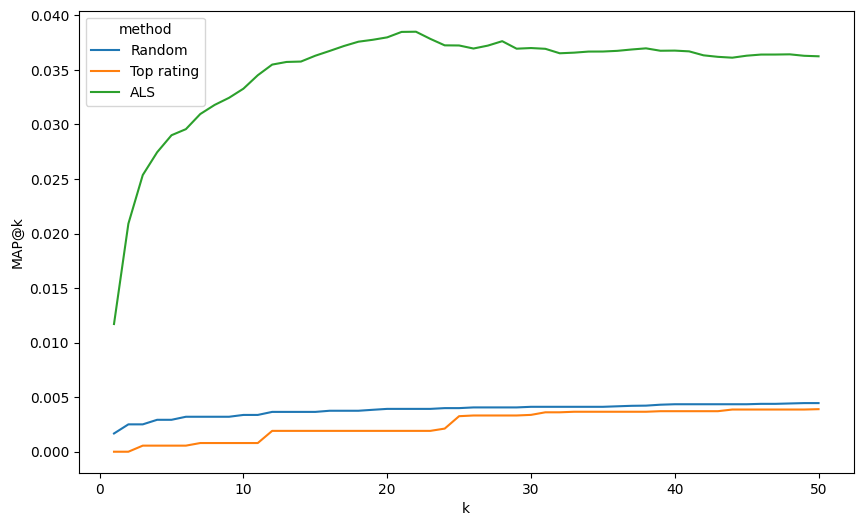

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(ks, random_mapk, label='Random')
plt.plot(ks, top_mapk, label='Top rating')
plt.plot(ks, als_mapk, label='ALS')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()

## Evaluation Metrics: Coverage and Personalization

### Coverage

Coverage is a metric used to measure the extent to which a recommendation system is able to recommend a diverse set of items. It indicates the proportion of unique items that are included in the recommendation lists across all users. A higher coverage suggests that the recommendation system is recommending a wider variety of items.

The formula for coverage is given by:

$$ \text{Coverage} = \frac{\text{Number of Unique Items in Recommendations}}{\text{Total Number of Items}} $$

In the context of evaluating recommendation systems, different recommendation algorithms may yield different coverages. Let's consider three scenarios using various recommendation algorithms: random, top rating, and ALS (Alternating Least Squares) matrix factorization.


### Personalization

Personalization is a metric that assesses how tailored the recommendations are to individual users. A high level of personalization indicates that the recommendations are unique and specific to each user, while a low level may suggest that recommendations are similar for different users.

To compute personalization, we utilize cosine similarity between the one-hot encoded user-item interaction matrix. The formula for personalization is given by:

$$ \text{Personalization} = 1 - \frac{\text{Sum of Similarity Scores} - N}{N \cdot (N - 1)} $$

Here, $N$ represents the number of users. The similarity scores are computed based on cosine similarity among user-item interaction vectors.


These metrics provide insights into the performance of recommendation systems beyond traditional accuracy measures, offering a more holistic evaluation of their effectiveness. The subsequent sections will delve into the computation of these metrics and provide code implementations.

In [81]:
from sklearn.metrics.pairwise import cosine_similarity


def coverage(preds):
    return np.unique(preds.flatten()).size / num_items


def personalization(preds):
    N = preds.shape[0]
    ohe_matrix = np.zeros((N, num_items))
    ohe_matrix[np.arange(N).repeat(preds.shape[1]), preds.reshape(-1)] = 1.
    sim_matrix = cosine_similarity(ohe_matrix)
    return 1 - (sim_matrix.sum() - N) / (N * (N - 1))

print(f'Random coverage: {coverage(random_preds):.4f}')
print(f'Top rating coverage: {coverage(top_preds):.4f}')
print(f'ALS coverage: {coverage(als_preds):.4f}')
print()

print(f'Random personalization: {personalization(random_preds):.4f}')
print(f'Top rating personalization: {personalization(top_preds):.4f}')
print(f'ALS personalization: {personalization(als_preds):.4f}')

Random coverage: 0.9571
Top rating coverage: 0.0051
ALS coverage: 0.1761

Random personalization: 0.9949
Top rating personalization: 0.0000
ALS personalization: 0.8470


In [82]:
test_relevant = get_y_test(test_ratings)
ks = np.arange(1, 51)
als_preds = ALS_prediction(als.X, als.Y, k=ks[-1])
print(als_preds.shape)
random_preds = random_prediction(test_ratings, num_items, k=ks[-1])
print(random_preds.shape)
top_preds = top_prediction(test_ratings, freq_thr=10, k=ks[-1])
print(top_preds.shape)

random_mapk = [MAPk(test_relevant, random_preds, k=k, average_by='k') for k in ks]
top_mapk = [MAPk(test_relevant, top_preds, k=k, average_by='k') for k in ks]
als_mapk = [MAPk(test_relevant, als_preds, k=k, average_by='k') for k in ks]

(610, 50)
(610, 50)
(610, 50)


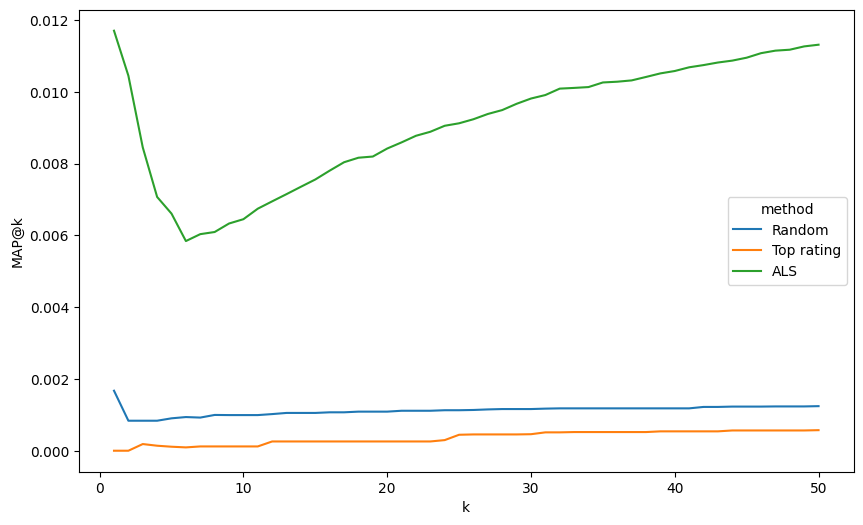

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(ks, random_mapk, label='Random')
plt.plot(ks, top_mapk, label='Top rating')
plt.plot(ks, als_mapk, label='ALS')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()